In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error

import xgboost as xgb
import lightgbm as lgbm

%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head(5)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
df_test.head(5)

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_IDs = df_train['ID']
y_train = df_train['target']
train_df = df_train.drop(['ID', 'target'], axis=1)

test_IDs = df_test['ID']
test_df = df_test.drop('ID', axis=1)

In [6]:
print("Train size: {}".format(train_df.shape[0]))
print("Test size: {}".format(test_df.shape[0]))

Train size: 4459
Test size: 49342


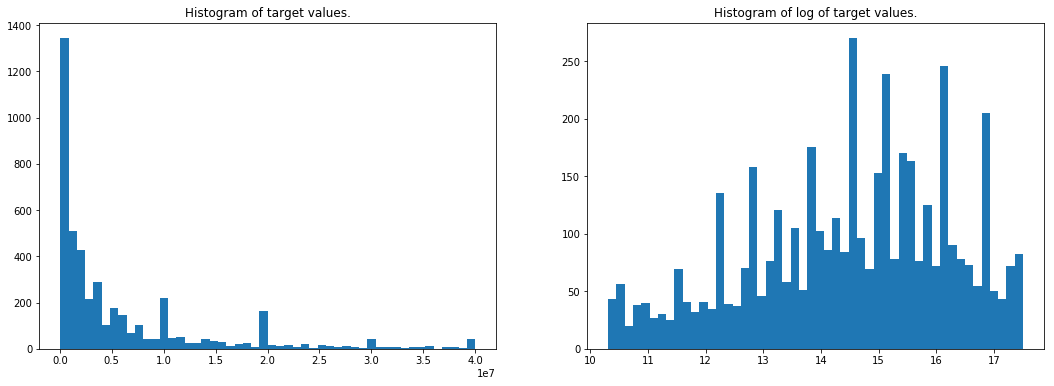

In [7]:
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=50)
plt.title('Histogram of target values.')
plt.subplot(1, 2, 2)
plt.hist(np.log(y_train), bins=50)
plt.title('Histogram of log of target values.')
plt.show()

### Check for missing values

#### Train

In [8]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


#### Test

In [9]:
missing_df = test_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


No missing values. However, this could mean that the NaN values were manually removed or imputed before the dataset was provided. For example, 0s might have formerly been missing values. Should check the correlation between the values of different features to make sure of this.

### Check for constant values

#### Train

In [10]:
unique_df_train = train_df.nunique().reset_index()
unique_df_train.columns = ["col_name", "unique_count"]
constant_df_train = unique_df_train[unique_df_train["unique_count"]==1]
constant_df_train.shape

(256, 2)

#### Test

In [11]:
unique_df_test = test_df.nunique().reset_index()
unique_df_test.columns = ["col_name", "unique_count"]
constant_df_test = unique_df_test[unique_df_test["unique_count"]==1]
constant_df_test.shape

(0, 2)

In [12]:
train_df = train_df.drop(constant_df_train['col_name'].values, axis=1)
test_df = test_df.drop(constant_df_train['col_name'].values, axis=1)

The features that are constant in the train set are not necessarily constant in the test set. For now, they are completely removed from both. However, there should be a way to make use of this information somehow.

### Scale and normalize the values

In [13]:
#Some basic stats for the features
train_df.describe()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,...,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4459.000000,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03,4.459000e+03
mean,1.465493e+04,1.390895e+03,2.672245e+04,4.530164e+03,2.640996e+04,3.070811e+04,1.686522e+04,4.669208e+03,2.569407e+06,1.552158e+05,...,4.676057e+05,4.446239e+05,8.056219e+05,7.812966e+05,143.529939,1.213809e+05,3.573451e+04,3.123741e+05,9.219960e+04,2.279100e+05
std,3.893298e+05,6.428302e+04,5.699652e+05,2.359124e+05,1.514730e+06,5.770590e+05,7.512756e+05,1.879449e+05,9.610183e+06,1.587815e+06,...,4.068038e+06,4.428889e+06,4.513246e+06,6.839451e+06,9584.318507,4.720709e+06,1.614622e+06,4.318501e+06,1.635993e+06,1.811139e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.000000e+07,4.000000e+06,2.000000e+07,1.480000e+07,1.000000e+08,2.070800e+07,4.000000e+07,1.040000e+07,3.196120e+08,6.000000e+07,...,7.600000e+07,1.235880e+08,1.300000e+08,1.444000e+08,640000.000000,3.013120e+08,1.064200e+08,1.400000e+08,6.176800e+07,4.320000e+07


In [14]:
#Might consider using a different scaler

#Fit and transform to train
x = train_df.values
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
scaled_train_df = pd.DataFrame(x_scaled, columns=train_df.columns)

#Transform test
x = test_df.values
x_scaled = scaler.transform(x)
scaled_test_df = pd.DataFrame(x_scaled, columns=test_df.columns)

In [15]:
scaled_train_df.describe()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
count,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,...,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000
mean,0.000733,0.000348,0.001336,0.000306,0.000264,0.001483,0.000422,0.000449,0.008039,0.002587,...,0.006153,0.003598,0.006197,0.005411,0.000224,0.000403,0.000336,0.002231,0.001493,0.005276
std,0.019466,0.016071,0.028498,0.015940,0.015147,0.027866,0.018782,0.018072,0.030068,0.026464,...,0.053527,0.035836,0.034717,0.047365,0.014975,0.015667,0.015172,0.030846,0.026486,0.041925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001877,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Check for duplicate columns

In [16]:
scaled_train_df.shape

(4459, 4735)

In [44]:
nodups_train_df = scaled_train_df.T.drop_duplicates().T
nodups_train_df.shape

(4459, 4692)

In [45]:
removed_columns = [col for col in scaled_test_df.columns if col not in nodups_train_df.columns]

In [46]:
scaled_test_df.shape

(49342, 4735)

### Check for correlation of the features

### Perform PCA

In [17]:
pca = PCA(n_components=0.95)
pca_train = pca.fit_transform(scaled_train_df)
pca_test = pca.transform(scaled_test_df)

# Some notes:

DONE - CAN BE IMPROVED - Quite a few features have constant values in the train set, but not in the test set. For now, they are completely removed, but is there a better way to take advantage of this? Maybe not deleting them is better? <br>
DONE - CAN BE IMPROVED - The value ranges for the features are not the same. A scaler is used to put all the features in the same range. Different types of scalers should be compared here. <br>
TO DO - Check for duplicate columns in train and test. Seems pandas has a built-in function. <br>
TO DO - High number of dimensions compared to dataset size. Should probably perform some kind of dimensionality reduction to get rid of some, seamingly, useless features. Maybe PCA or some other technique. Refer to some kernel for more information. <br>
"In practice, TruncatedSVD is very useful for highly sparse datasets which cannot be centered without making the memory usage explode.": https://www.kaggle.com/ishaan45/lgbm-with-tsvd <br>
TO DO - Maybe some sort of exploration for each of the features should be made. Or at least, the most important features should be found according to some model. <br>
TO DO - Some feature engineering might be possible? E.g. sum of zeros, or sum of values in a given row. <br>
Also, using KMeans clustering to add new features: https://www.kaggle.com/samratp/aggregates-sumvalues-sumzeros-k-means-pca <br>
TO DO - Most values are low values. In other words, target is heavily skewed. Needs to be looked into. <br>
TO DO - Test size is a lot bigger than the train. This could suggest a semi-supervised approach should be considered. <br>
TO DO - Train test split to build a validation set. KFold Cross validation might also be useful here (and quite doable since the dataset is not that big).
TO DO - Choose a model that is suited for the problem at hand. <br>
"LGBM is a new powerful alternative to XGBoost. It is gradient boosting machine which focuses on leaf wise tree growth rather than level wise tree growth which ensures fast learning and high accuracy. It is quiet difficult to train LGBM because there are huge number of parameters so it is advised to at least 
work on some core parameters while training your model.": https://www.kaggle.com/ishaan45/lgbm-with-tsvd <br>
TO DO - Choose more than one model, and take an average/weighted average of the predictions. <br>

## Build Train and Test set

In [32]:
x_train = np.array(pca_train)
y_train = np.array(np.log1p(y_train))

x_test = np.array(pca_test)

In [55]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1)

## Cross Validation

In [33]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgbm.Dataset(train_X, label=train_y)
    lgval = lgbm.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgbm.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for train_index, test_index in kf.split(x_train):
    pred_test, model, evals_result = run_lgb(x_train[train_index], y_train[train_index], x_train[test_index], y_train[test_index], x_test)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.50479
[400]	valid_0's rmse: 1.48857
[600]	valid_0's rmse: 1.48559
Early stopping, best iteration is:
[678]	valid_0's rmse: 1.48477
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.54972
[400]	valid_0's rmse: 1.52906
[600]	valid_0's rmse: 1.52561
Early stopping, best iteration is:
[618]	valid_0's rmse: 1.52494
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.55593
[400]	valid_0's rmse: 1.53587
[600]	valid_0's rmse: 1.52757
[800]	valid_0's rmse: 1.52485
Early stopping, best iteration is:
[798]	valid_0's rmse: 1.52469
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.58837
[400]	valid_0's rmse: 1.57571
Early stopping, best iteration is:
[383]	valid_0's rmse: 1.5751
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.54834
[400]	valid_0's rmse: 1.52657
[600]	

In [ ]:
m = RandomForestRegressor(n_estimators=10)
kf = KFold(n_splits=10)
rmsle = []
for train_index, test_index in kf.split(x_train):
    m.fit(x_train[train_index], y_train[train_index])
    val_pred = m.predict(x_train[test_index])
    rmsle.append(np.sqrt(mean_squared_log_error(y_test[test_index], val_pred)))

In [ ]:
np.mean(rmsle)

## Output Generation

In [36]:
f = open('y_pred.csv', 'w')
f.write("ID,target\n")

for idn, pred in zip(test_IDs, pred_test_full):
    f.write("{},{}\n".format(idn, pred))
f.flush()
f.close()